# **UAV detection Neural network**

## Preparation

In [ ]:
import zipfile
import pathlib
import numpy as np

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("dataset_v1.zip", "r")
zip_ref.extractall()
zip_ref.close()

data_dir = pathlib.Path("dataset_v1/train/")

# Get the class names for our dataset
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)



In [ ]:
import os
# Go through the dataset_v1 directory and list the number of files
for dirpath, dirnames, filenames in os.walk("dataset_v1"):
  print(f"In '{dirpath}' {len(dirnames)} catalogs and {len(filenames)} images.")

In [ ]:
import shutil
import os

# Path to the .ipynb_checkpoints directory
checkpoints_path = '__MACOSX'

# Check if the directory exists
if os.path.exists(checkpoints_path):
    # Remove the directory and all its contents
    shutil.rmtree(checkpoints_path)
    print(".ipynb_checkpoints directory has been removed")
else:
    print(".ipynb_checkpoints directory does not exist")

## Dates

### Data visualization

In [19]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

In [20]:
# Viewing an image
def view_random_image():
  # Create a destination directory (we'll be viewing images from here)
  target_folder = "dataset_v1/train/plane"

  # Get a random path to the image
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read image and plot using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(random_image[0])
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (400, 400, 3)


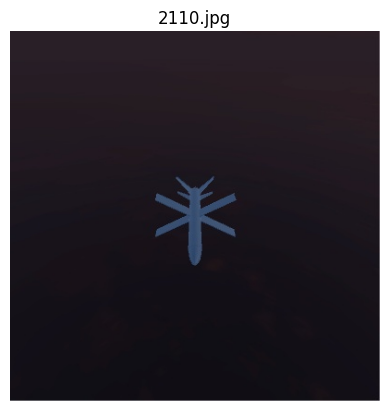

In [21]:
# Viewing a random image from the training dataset
img = view_random_image()

### Data Preprocessing

In [ ]:
import os

In [ ]:
def items_in_set(path_of_set):
  for dirpath, dirnames, filenames in os.walk(path_of_set):
    print(f"In '{dirpath}' {len(dirnames)} catalogs and {len(filenames)} images.")

In [22]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

In [23]:
BATCH_SIZE = 32
IMAGES_SIZE = (224, 224)
SEED = 42

#### No data augmentation

In [ ]:
# Set the seed
tf.random.set_seed(SEED)

# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)
valid_datagen = ImageDataGenerator(rescale=1/255.)

# Setup the train and test directories
train_dir = "dataset_v1/train/"
test_dir = "dataset_v1/test/"
valid_dir = "dataset_v1/valid/"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=BATCH_SIZE, # number of images to process at a time
                                               target_size=IMAGES_SIZE, # convert all images to be 224 x 224
                                               class_mode="binary", # type of problem we're working on
                                               seed=SEED)

test_data = test_datagen.flow_from_directory(test_dir,
                                             batch_size=BATCH_SIZE,
                                             target_size=IMAGES_SIZE,
                                             class_mode="binary",
                                             seed=SEED)

valid_data = valid_datagen.flow_from_directory(valid_dir,
                                               batch_size=BATCH_SIZE,
                                               target_size=IMAGES_SIZE,
                                               class_mode="binary",
                                               seed=SEED)

Found 8400 images belonging to 2 classes.
Found 1800 images belonging to 2 classes.
Found 1800 images belonging to 2 classes.


In [ ]:
images, labels = train_data.next()
labels

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

#### Data augmentation

In [ ]:
# Set the seed
tf.random.set_seed(SEED)

# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
train_datagen_augmented = ImageDataGenerator(rescale=1/255.) # flip the image on the horizontal axis
test_datagen = ImageDataGenerator(rescale=1/255.)
valid_datagen = ImageDataGenerator(rescale=1/255.)

# Setup the train and test directories
train_dir = "dataset_v1/train/"
test_dir = "dataset_v1/test/"
valid_dir = "dataset_v1/valid/"

# Import data from directories and turn it into batches
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                   target_size=(224, 224),
                                                                   batch_size=32,
                                                                   class_mode='binary',
                                                                   seed=SEED)

test_data = test_datagen.flow_from_directory(test_dir,
                                             batch_size=BATCH_SIZE,
                                             target_size=IMAGES_SIZE,
                                             class_mode="binary",
                                             seed=SEED)

valid_data = valid_datagen.flow_from_directory(valid_dir,
                                               batch_size=BATCH_SIZE,
                                               target_size=IMAGES_SIZE,
                                               class_mode="binary",
                                               seed=SEED)

In [164]:
# Get data batch samples
#images, labels = train_data.next()
augmented_images, augmented_labels = train_data_augmented.next() # Note: labels aren't augmented, they stay the same

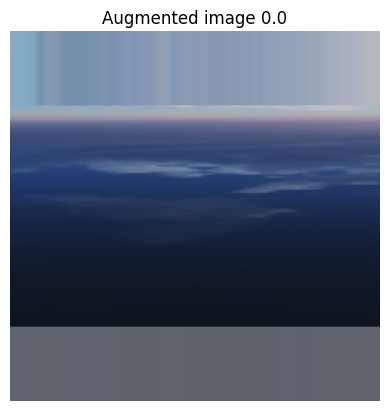

In [165]:
# Show original image and augmented image
random_number = random.randint(0, 31) # we're making batches of size 32, so we'll get a random instance
#plt.imshow(images[random_number])
#plt.title(f"Original image")
#plt.axis(False)
plt.figure()
plt.imshow(augmented_images[random_number])
plt.title(f"Augmented image {augmented_labels[random_number]}")
plt.axis(False);

## Building the Model

In [171]:
# Create a CNN model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=5,
                         kernel_size=3, # can also be (3, 3)
                         activation="relu",
                         input_shape=(224, 224, 3)), # first layer specifies input shape (height, width, colour channels)
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation="sigmoid") # binary activation output
])


# Compile the model
model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
training = model.fit(train_data_augmented,
                        epochs=3,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/3
263/263 [==============================] - 23s 84ms/step - loss: 1.1222 - accuracy: 0.6581 - val_loss: 0.5068 - val_accuracy: 0.7883
Epoch 2/3
263/263 [==============================] - 23s 89ms/step - loss: 0.2806 - accuracy: 0.9281 - val_loss: 0.1756 - val_accuracy: 0.9761
Epoch 3/3
263/263 [==============================] - 22s 85ms/step - loss: 0.1329 - accuracy: 0.9732 - val_loss: 0.1162 - val_accuracy: 0.9650


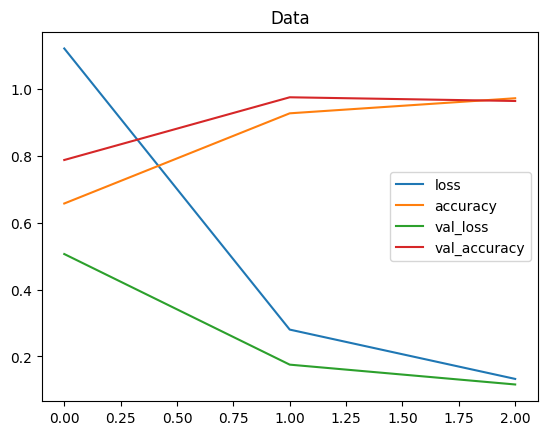

In [172]:
pd.DataFrame(training.history).plot(title="Data");

In [ ]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();


plot_loss_curves(training)

In [173]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 222, 222, 5)       140       
                                                                 
 flatten_4 (Flatten)         (None, 246420)            0         
                                                                 
 dense_10 (Dense)            (None, 1)                 246421    
                                                                 
Total params: 246561 (963.13 KB)
Trainable params: 246561 (963.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [179]:
model.evaluate(test_data)

57/57 [==============================] - 3s 60ms/step - loss: 0.1237 - accuracy: 0.9567


[0.12374287843704224, 0.9566666483879089]

In [ ]:
!wget https://fs.net-film.ru/fs51151b.jpg

In [138]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

1/1 [==============================] - 0s 18ms/step
0.0037671137


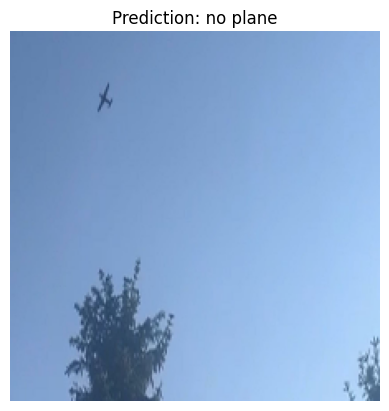

In [193]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))
  print(pred[0][0])

  # Get the predicted class
  pred_class = class_names[int(tf.round(pred)[0][0])]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

# Test our model on a custom image
pred_and_plot(model, "test1.jpg", ['no plane', 'plane'])

1/1 [==============================] - 0s 18ms/step
0.83367026


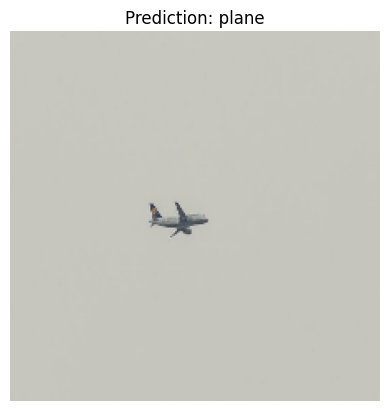

In [194]:
pred_and_plot(model, "test2.jpg", ['no plane', 'plane'])

1/1 [==============================] - 0s 16ms/step
0.4939609


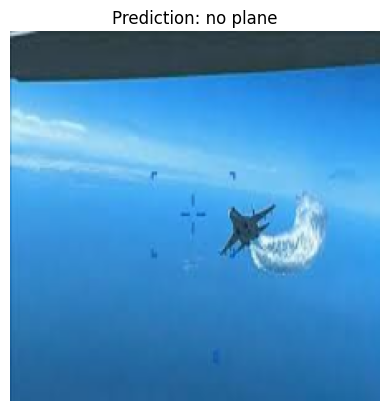

In [195]:
pred_and_plot(model, "test3.jpg", ['no plane', 'plane'])

1/1 [==============================] - 0s 17ms/step
0.52774566


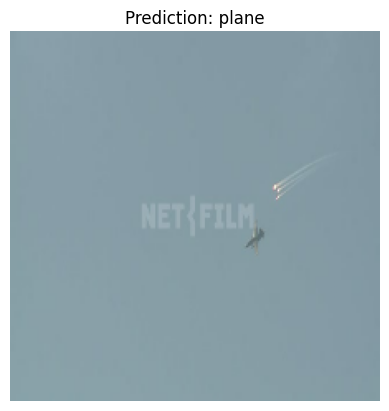

In [196]:
pred_and_plot(model, "test4.jpg", ['no plane', 'plane'])